# EDA y Generacion del modelo de MLL.

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split,  GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from db_connection import get_engine

### Se obtiene y se visualiza una muestra de los datos con los que se va a crear el modelo de machine learning.

In [5]:
engine = get_engine()
query = "SELECT * FROM casas"
df_pisos = pd.read_sql(query, engine)
# Se eliminan columnas innecesarias 
df_pisos = df_pisos.drop(columns=['idcasas', 'referencia', 'fecha_agregacion'])

In [6]:
df_pisos.head()

,titulo,localizacion,precio,ascensor,baños,trastero,piso,habitaciones,metros_reales,armarios_empotrados,terraza,garaje,calefaccion,aire_acondicionado,piscina,zonas_verdes
0,"Alquiler de Dúplex en cuesta Corvales, 3",La Zubia,890,1,2,0,Primeros_pisos,2,85,1,1,1,1,1,0,0
1,Alquiler de Piso en calle Paraíso,"Bola de Oro, Granada",850,0,1,0,Bajo,2,85,1,0,0,0,1,0,0
2,Alquiler de Piso en calle Estepona,"Carrera de la Virgen - Paseo del Salón, Granada",700,1,1,0,Primeros_pisos,1,45,0,0,0,0,0,0,0
3,Alquiler de Chalet adosado en calle Logroño,La Zubia,780,0,2,0,Muchas_plantas,3,72,0,1,1,0,0,0,0
4,"Alquiler de Piso en calle Santiago, 3","Cuesta Escoriaza - Barranco del Abogado, Granada",950,0,1,0,Primeros_pisos,3,80,0,1,0,1,1,0,0


## Eliminar pisos con pocos m2

In [7]:
#Eliminar pisos con pocos metros cuadrados mediante Umbral Dinamico
# Calcular el percentil 1% de la columna 'metros_reales'
# Esto se hace para eliminar outliers que puedan afectar el modelo
threshold = np.percentile(df_pisos['metros_reales'], 1)  # Percentil 1% de los m2 de todos los pisos
umbral_final = max(threshold, 20)  # Si el percentil esta por debajo de 20 se asegura eliminar cualquier piso con menos de 20m2
df_filtrado = df_pisos[df_pisos['metros_reales'] >= umbral_final] # Se filtra el df

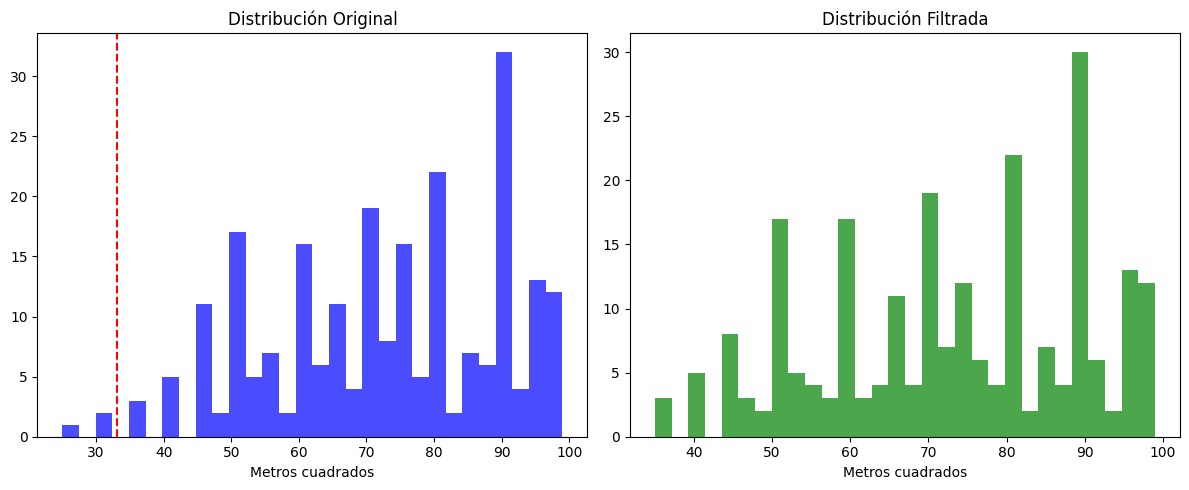

In [8]:
# Histograma antes
plt.figure(figsize=(12, 5)) # Crear figura completa
plt.subplot(1, 2, 1) # Primera división de la figura
plt.hist(df_pisos['metros_reales'], bins=30, color='blue', alpha=0.7) # Datos que se van a mostrar
plt.axvline(umbral_final, color='red', linestyle='--') # Dibujar el umbral que se ha asignado
plt.title('Distribución Original')
plt.xlabel('Metros cuadrados')

# Histograma después
plt.subplot(1, 2, 2) # Segunda división de la figura
plt.hist(df_filtrado['metros_reales'], bins=30, color='green', alpha=0.7) # Datos que se van a mostrar
plt.title('Distribución Filtrada')
plt.xlabel('Metros cuadrados')

plt.tight_layout() #Ajuste de margenes
plt.show()

Resultado gráfico de la distribución de pisos tras eliminar el 1 percentil de la columna metros_reales. Con esto se ha logrado eliminar aquellas casas cuyos metros_reales estaban mal indicados y alterarian negativamente el resultado del modelo predictivo.

##  Transformaciones de variables categóricas a variables dummy o numéricas (One-Hot Encoding).

Como en las variables categóricas no hay un orden determinado, haremos directamente un get_dummies. Este paso es ensecial para que el modelo pueda procesar 'localizacion' y 'piso' correctamente.

In [9]:
df_pisos = pd.get_dummies(df_filtrado, dtype='int', columns=["localizacion","piso"])

Muestra del dataframe tras la transformación de las variables categóricas a variables numéricas.

In [10]:
df_pisos.head()

,titulo,precio,ascensor,baños,trastero,habitaciones,metros_reales,armarios_empotrados,terraza,garaje,...,"localizacion_San Matías - Pavaneras, Granada","localizacion_Zaidín, Granada","localizacion_Zona Parque de San Roque, Churriana de la Vega","localizacion_Zona Parque de la Ermita, Churriana de la Vega","localizacion_Zona Poniente, Armilla","localizacion_Área de Granada, Granada",piso_Bajo,piso_Muchas_plantas,piso_Primeros_pisos,piso_Ultimos_pisos
0,"Alquiler de Dúplex en cuesta Corvales, 3",890,1,2,0,2,85,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,Alquiler de Piso en calle Paraíso,850,0,1,0,2,85,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Alquiler de Piso en calle Estepona,700,1,1,0,1,45,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Alquiler de Chalet adosado en calle Logroño,780,0,2,0,3,72,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,"Alquiler de Piso en calle Santiago, 3",950,0,1,0,3,80,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Ridge regression. Primera prueba sin dividir en datos de entrenamiento y prueba.

Primero asignamos a X el df de caracteristicas a Y el df solo con el precio que es lo que queremos predecir.

In [11]:
# Se guardan caracteristicas en la variable x y precio que es la variable objetivo en la y. axis=1 indica que queremos eliminar columnas y no registros.
x, y = df_pisos.drop(["precio","titulo"], axis=1), df_pisos["precio"]

In [12]:
# Se prepara del mismo modo una variable que contendrá una lista con todos características
vars_pisos = list(df_pisos.columns)
vars_pisos.remove('precio')
vars_pisos.remove('titulo')

1. Se inicializa el modelo. 
2. Se entrena el modelo. 
3. Obtenemos el intercepto. 
4. Se visualiza los coeficientes aprendidos por el modelo. Los positivos indica que a medida que al característica aumenta también lo hace el precio y viceversa con los negativos.

model intercept: 402.422182


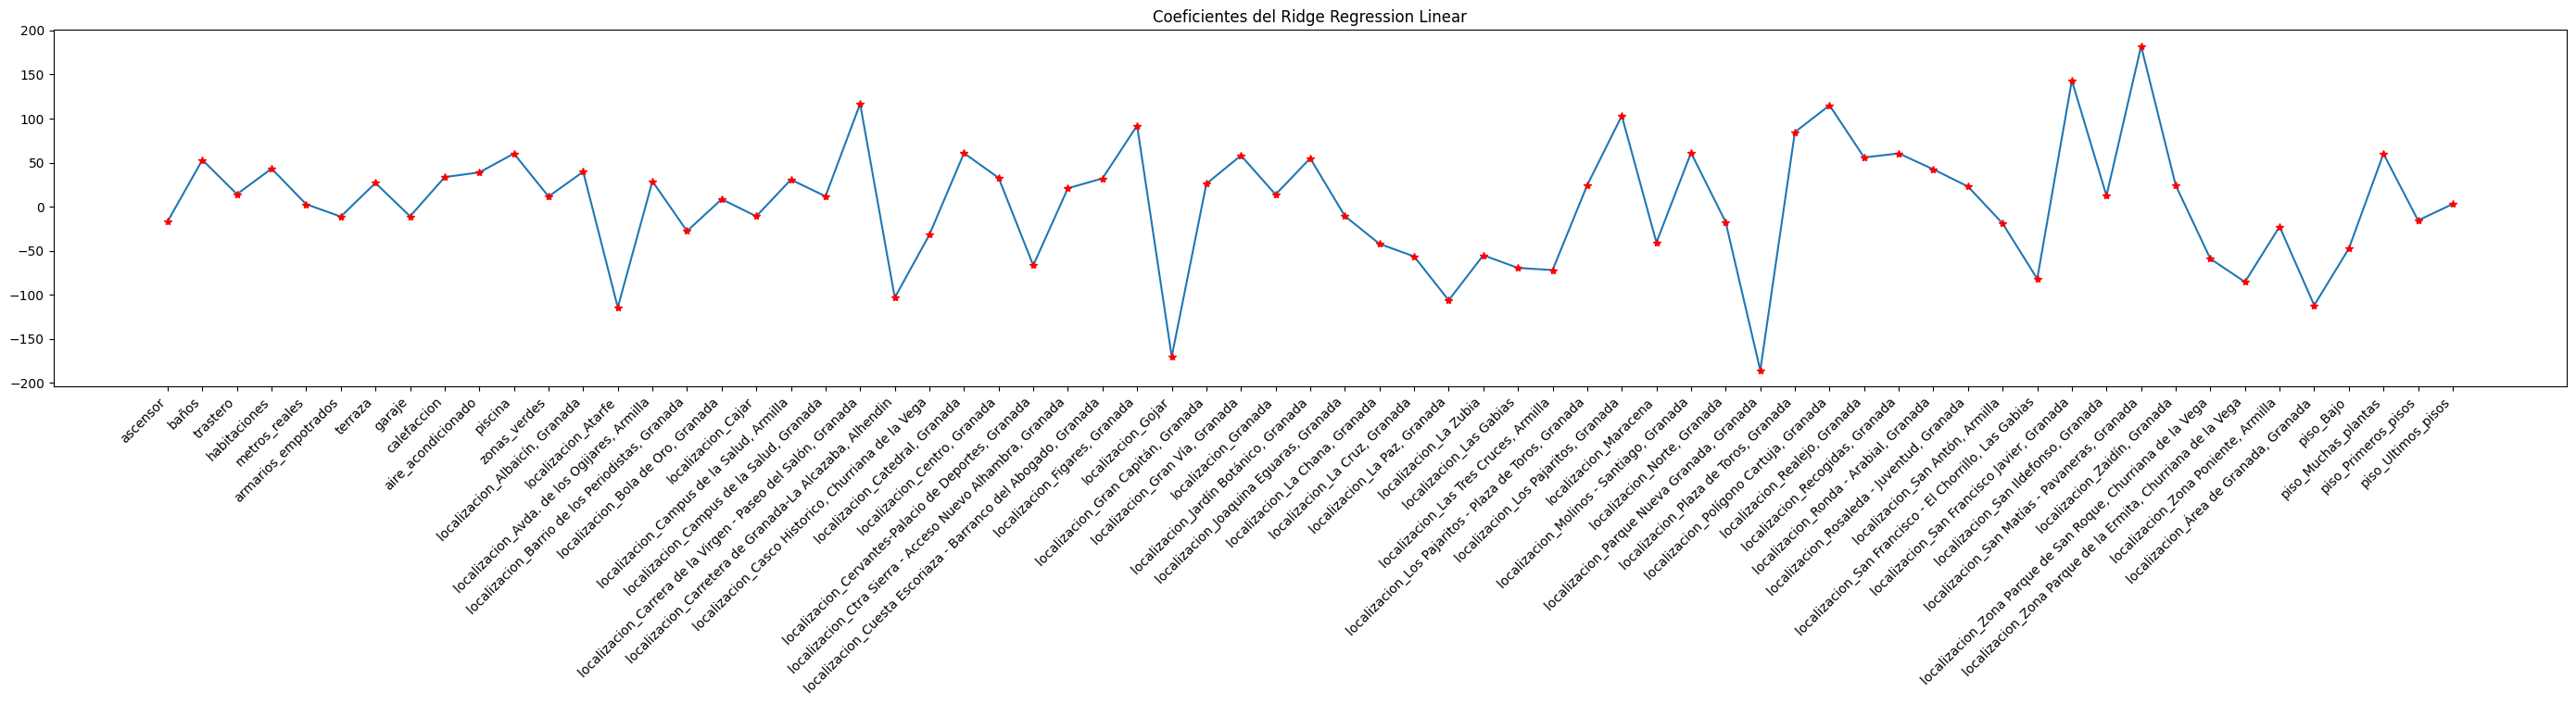

In [13]:
# Crear instancia de modelo regresión linear con regularizacion Ridge
lr_m = Ridge()
# Ajuste sobre la muestra completa, sin division de datos de entrenamiento y prueba
lr_m.fit(x, y)
# Imprimir el intercepto. 
print('model intercept: %f' % lr_m.intercept_)

plt.figure(figsize=(35,5))
plt.xticks(range(len(vars_pisos)), vars_pisos, rotation=45, ha='right')
plt.title('Coeficientes del Ridge Regression Linear')
_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_.T, 'r*')


### Estimacion de precio con el MAE.

### Primer cálculo del MAE.

Se realiza una primera predicción para obtener el mae de inicio y el R^2.

MAE: 86.494
R^2: 0.531


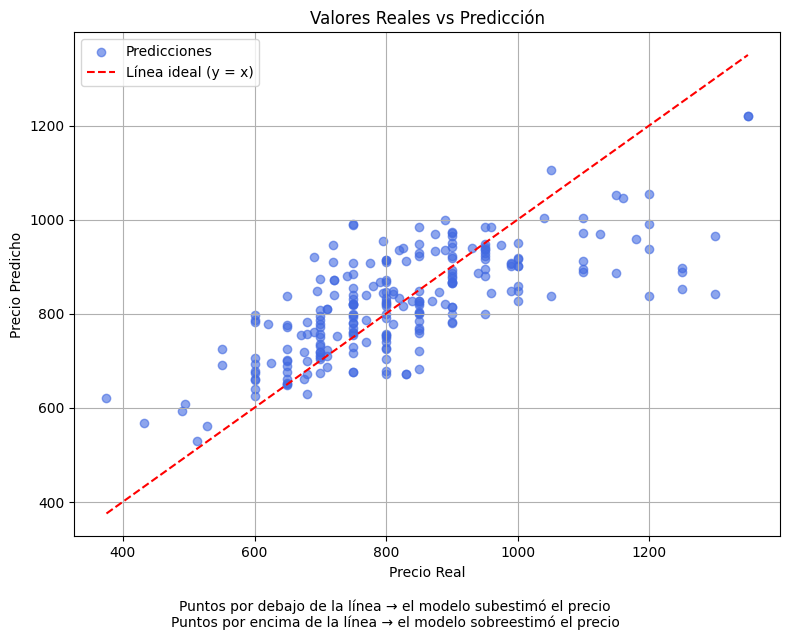

In [14]:
# Predecir el valor del precio
y_pred = lr_m.predict(x)

# Evaluacion del modelo mostrando el error absoluto medio y R^2 (coeficiente de determinacion)
print("MAE: %.3f" % (mean_absolute_error(y, y_pred)))
print("R^2: %.3f" % (lr_m.score(x, y)))

# Crear gráfico comparativo entre los valores reales y la predicciones
plt.figure(figsize=(8, 6))
plt.title("Valores Reales vs Predicción")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")

plt.scatter(y, y_pred, alpha=0.6, label="Predicciones", color="royalblue") # Puntos azules que representan las predicciones
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Línea ideal (y = x)") # Linea de resultado ideal
plt.legend() # Mostrar leyenda
plt.grid(True)

# Nota explicativa
plt.figtext(0.5, -0.05,
            "Puntos por debajo de la línea → el modelo subestimó el precio\n"
            "Puntos por encima de la línea → el modelo sobreestimó el precio",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

Se ha obtenido un MAE de 90.894 y un R^2 de 0.529.  
Estos datos son mejorables. Se va realizar una división en datos de entrenamiento y prueba para intentar mejorarlo.

### División en datos de entrenamiento y prueba.

In [15]:
# Dividir los datos en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Ajustar el modelo en los datos de entrenamiento
lr_m.fit(X_train, y_train)

# Probar el modelo con los datos de prueba
y_pred = lr_m.predict(X_test)

# Evaluacion del modelo
print("MAE: %.3f" % (mean_absolute_error(y_test, y_pred)))
print("R^2: %.3f" % (lr_m.score(x, y)))

MAE: 95.627
R^2: 0.506


Se han obtenido resultados peores, es algo esperable.  
Ahora se va proseguir realizando una validación cruzada para evaluar mejor el modelo.

### Validación cruzada y ajuste de hiperparámetros.

In [16]:
# Definir el modelo
lr_m = Ridge()

# Usar R² directamente porque ya es una métrica integrada
scores_r2 = cross_val_score(lr_m, x, y, cv=5, scoring='r2')

# Para el MAE se define el scorer personalizado 
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
scores_mae = cross_val_score(lr_m, x, y, cv=5, scoring=mae_scorer)

# Se muestran los resultados
print("MAE promedio (cross-val): %.3f" % (-np.mean(scores_mae)))
print("R² promedio (cross-val): %.3f" % np.mean(scores_r2))

MAE promedio (cross-val): 114.726
R² promedio (cross-val): 0.181


Se va a aplicar GridSearchCV para buscar el mejor alpha posible y su resultado.

In [17]:
# Definir el rango de valores para alpha
param_grid_lr_m = {'alpha': [0.01, 0.1, 1, 10, 100, 500, 1000]}

# Crear modelo base
ridge = Ridge()

# Configurar GridSearch con validación cruzada
grid_search_lr_m = GridSearchCV(estimator=ridge,
                                param_grid=param_grid_lr_m, 
                                scoring='neg_mean_absolute_error', cv=5)

# Ajustar a los datos
grid_search_lr_m.fit(x, y)

# Mostrar el mejor valor de alpha y su resultado
print("Mejor alpha:", grid_search_lr_m.best_params_['alpha'])
print("MAE (validación cruzada): %.3f" % -grid_search_lr_m.best_score_)

Mejor alpha: 500
MAE (validación cruzada): 108.944


Aunque se ha obtenido peores resultados que al principio, el modelo ahora es más realista.  
Con la división de los datos se evita un sobreajuste y junto con la validación cruzada el modelo predice sobre datos que no ha visto durante el entrenamiento.

## RandomForestRegressor.

Se va a probar ahora aplicando el modelo RandomForestRegressor que funciona mejor con datos ruidosos y no lineales.

In [18]:
# Crear el modelo RandomForestRegressor con la semilla 42 para evitar muestreos aleatorios y reproducir los mismos resultados
rf = RandomForestRegressor(random_state=42)

# Ajustar el modelo a los datos de entrenamiento
rf.fit(X_train, y_train)

# Probar el modelo con los datos de prueba
y_pred_rf = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

MAE: 83.5918439716312
R²: 0.44285584982725834


Se realiza validación cruzada para este modelo también.

In [19]:
y_pred_cv_rf = cross_val_predict(rf, x, y, cv=5)
print("MAE (cross-val):", mean_absolute_error(y, y_pred_cv_rf))
print("R² (cross-val):", r2_score(y, y_pred_cv_rf))

MAE (cross-val): 112.64189479905437
R² (cross-val): 0.1556340882221673


Se va a probar a realizar un GridSearchCV para encontrar los mejores parámetros para el modelo.

In [20]:
# Definir los parámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Numero de arboles
    'max_depth': [None, 10, 20, 30], # Profundidad de cada arbol
    'min_samples_split': [2, 5, 10], # Minimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4], # Minimo de muestras necesarias en una hora
    'max_features': ['sqrt', 'log2'] # Numero de caracteristicas a considerar al dividir un nodo
}

# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_mean_absolute_error')

# Ajustar el modelo
grid_search_rf.fit(X_train, y_train)

# Resultados
print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"Mejor puntuación (MAE): {-grid_search_rf.best_score_}")


Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor puntuación (MAE): 105.94343243243243


Se ha mejorado el MAE. Se va a realizar un un par de pruebas más con ajustes diferentes para ver si se puede encontrar un resultado mejor.

Se incrementa el número de arboles (n_estimators).

In [21]:
# Definir los parámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_mean_absolute_error')

# Ajustar el modelo
grid_search_rf.fit(X_train, y_train)

# Resultados
print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"Mejor puntuación (MAE): {-grid_search_rf.best_score_}")


Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor puntuación (MAE): 105.94343243243243


Se incrementa la profundidad.

In [22]:
# Definir los parámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_mean_absolute_error')

# Ajustar el modelo
grid_search_rf.fit(X_train, y_train)

# Resultados
print(f"Mejores parámetros: {grid_search_rf.best_params_}")
print(f"Mejor puntuación (MAE): {-grid_search_rf.best_score_}")

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor puntuación (MAE): 105.94343243243243


Cuando se ha aumentado el número de arboles no ha habido mejoría ninguna en el MAE y en el caso de aumentar la profundidad le mejora ha sido ínfima.

## GradientBoostingRegressor.


Se va a probar un último modelo GradientBoostingRegressor.

In [23]:
# Crear el modelo
gbr = GradientBoostingRegressor(random_state=42)

# Validación cruzada con MAE negativo se niega el valor para tener el resultado positivo
mae_scores = -cross_val_score(gbr, x, y, scoring='neg_mean_absolute_error', cv=5)
r2_scores = cross_val_score(gbr, x, y, scoring='r2', cv=5)

# Ajustar el modelo a los datos 
gbr.fit(x, y)

# Resultados
print("MAE promedio (cross-val): %.3f" % mae_scores.mean())
print("R² promedio (cross-val): %.3f" % r2_scores.mean())

MAE promedio (cross-val): 119.558
R² promedio (cross-val): 0.039


In [24]:
# Definir los parametros a probar
param_grid_gbr = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

# Crear el modelo
gbr = GradientBoostingRegressor(random_state=42)

# Configurar GridSearchCV
grid_search_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    scoring='neg_mean_absolute_error',  # Para minimizar el MAE
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo a los datos
grid_search_gbr.fit(x, y)

# Resultados
print("Mejores parámetros:", grid_search_gbr.best_params_)
print("Mejor MAE (validación cruzada):", -grid_search_gbr.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Mejor MAE (validación cruzada): 114.10796036199807


## Comparación entre los modelos.

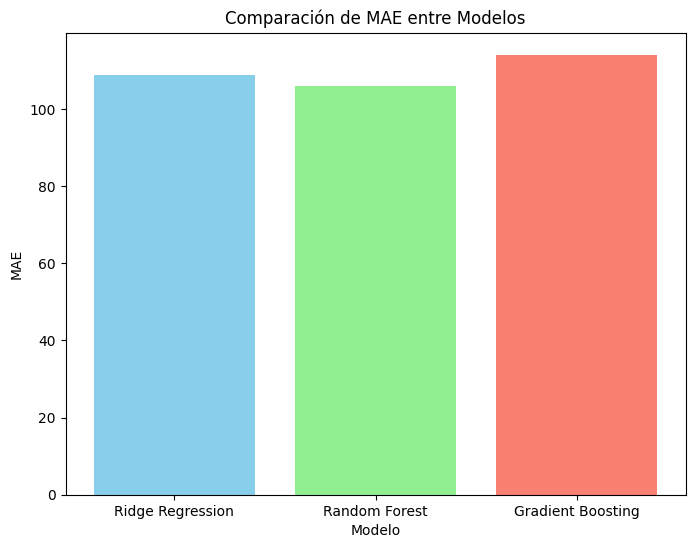

In [25]:
# Crear un diccionario con los MAE de cada modelo
mae_resultados = {
    "Ridge Regression": -grid_search_lr_m.best_score_,
    "Random Forest": -grid_search_rf.best_score_,
    "Gradient Boosting": -grid_search_gbr.best_score_
}

# Crear un gráfico de barras para comparar los MAE de los modelos
plt.figure(figsize=(8, 6))
plt.bar(mae_resultados.keys(), mae_resultados.values(), color=['skyblue', 'lightgreen', 'salmon'])

# Añadir etiquetas y título
plt.title('Comparación de MAE entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('MAE')

# Mostrar el gráfico
plt.show()

Observamos que los mejores resultados han sido con Random Forest.

In [26]:
# Guardar los mejores modelos y sus resultados en un diccionario
mejores_modelos = {
    "Ridge Regression": (grid_search_lr_m.best_estimator_, -grid_search_lr_m.best_score_),
    "Random Forest": (grid_search_rf.best_estimator_, -grid_search_rf.best_score_),
    "Gradient Boosting": (grid_search_gbr.best_estimator_, -grid_search_gbr.best_score_)
}

# Elegir el modelo con el menor MAE
mejor_modelo = min(mejores_modelos.items(), key=lambda x: x[1][1])

# Obtener el mejor estimador y predecir con él
mejor_estimador = mejor_modelo[1][0]
y_pred = mejor_estimador.predict(x)
# Calcular el R² sobre todo el conjunto de datos
r2 = r2_score(y, y_pred)
# Mostrar el mejor modelo y su MAE
print("Mejor modelo:", mejor_modelo[0])
print("MAE:", mejor_modelo[1][1])
print("R²:", r2)



Mejor modelo: Random Forest
MAE: 105.94343243243243
R²: 0.8343495544917681


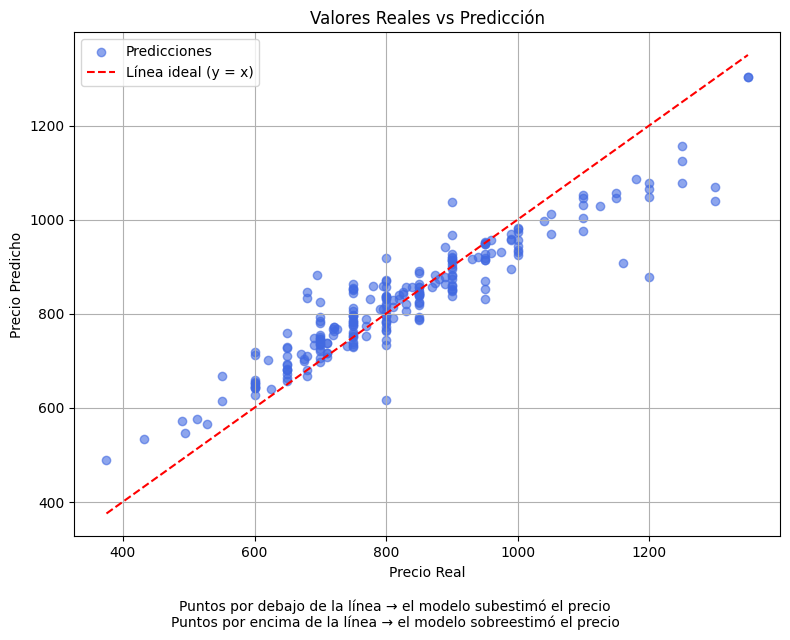

<Figure size 640x480 with 0 Axes>

In [ ]:
# Crear gráfico comparativo entre los valores reales y la predicciones
plt.figure(figsize=(8, 6))
plt.title("Valores Reales vs Predicción")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")

plt.scatter(y, y_pred, alpha=0.6, label="Predicciones", color="royalblue") # Puntos azules que representan las predicciones
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Línea ideal (y = x)") # Linea de resultado ideal
plt.legend() # Mostrar leyenda
plt.grid(True)

# Nota explicativa
plt.figtext(0.5, -0.05,
            "Puntos por debajo de la línea → el modelo subestimó el precio\n"
            "Puntos por encima de la línea → el modelo sobreestimó el precio",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

Observamos como el gráfico de predicciones ha mejorado respecto al gráfico inicial.

### Coeficientes de cada modelo.

Coeficientes del Random Forest.

In [108]:
rf_estimador = grid_search_rf.best_estimator_
pd.DataFrame(rf_estimador.feature_importances_,
             vars_pisos,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
metros_reales,0.228337
habitaciones,0.149747
baños,0.050294
aire_acondicionado,0.038487
terraza,0.032501
...,...
"localizacion_Parque Lagos, Granada",0.000205
"localizacion_Zona Polideportivo, Alhendin",0.000136
"localizacion_Híjar, Las Gabias",0.000000
"localizacion_San Francisco - El Chorrillo, Las Gabias",0.000000


Coeficientes del Ridge Regression.

In [109]:
lr_estimador = grid_search_lr_m.best_estimator_
pd.DataFrame(lr_estimador.coef_,
             vars_pisos,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
"localizacion_San Matías - Pavaneras, Granada",161.199612
"localizacion_Carrera de la Virgen - Paseo del Salón, Granada",157.981453
"localizacion_Figares, Granada",146.817666
"localizacion_Realejo, Granada",145.376537
"localizacion_Gran Vía, Granada",135.079173
...,...
localizacion_Atarfe,-143.049111
"localizacion_Parque Nueva Granada, Granada",-153.097407
"localizacion_La Paz, Granada",-157.303025
localizacion_Gojar,-160.691165


Coeficientes del Gradient Boosting.

In [111]:
gbr_estimador = grid_search_gbr.best_estimator_
pd.DataFrame(gbr_estimador.feature_importances_,
             vars_pisos,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
metros_reales,0.261455
habitaciones,0.220170
aire_acondicionado,0.042791
piso_Ultimos_pisos,0.032412
"localizacion_Figares, Granada",0.024648
...,...
"localizacion_Casco Historico, Churriana de la Vega",0.000140
"localizacion_Bola de Oro, Granada",0.000116
"localizacion_Avda. de los Ogijares, Armilla",0.000000
"localizacion_San Antón, Armilla",0.000000


Tras ver los coeficientes y probar cada modelo en la web, se ha llegado a la conclusión de que se va a trabajar con el modelo de Ridge Regression. En la teoría esta dando un MAE y un R^2 algo peores que el Random Forest pero en la práctica es el que esta dando resultados más realistas para el contexto donde aplica.

# Exportar modelo y encoders.

In [1]:
MODELO = "generado/modelo_mll.pkl"
ENCODERS = "generado/encoded_columns.npy"

In [ ]:
# Guardar el modelo
with open(MODELO, 'wb') as f:
    pickle.dump(lr_estimador, f)


In [ ]:
features = df_pisos.drop(columns=['titulo', 'precio']).columns
# Guardar encoders
np.save(ENCODERS, features)